In [39]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [169]:
df_wheel = pd.read_csv('data/WHEEL.csv')
df_cam = pd.read_csv('data/CAMERA.csv')

In [170]:
def subtract_from_prev_val(df, col, init_val=0):
    return (df[col] - df.shift()[col])
def integrate_col(df, fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = df[fxdx_col].tolist()
    dx_l = df[dx_col].tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * fxdx_l[i]
        y[i] = y_val
        prev_val = y_val
        
    return np.array(y)

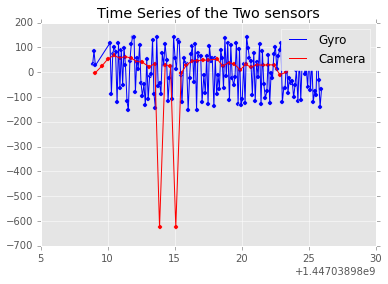

In [171]:
plt.plot(df_wheel['timestamp'], df_wheel['gz'] - df_wheel['gz'].mean(), c = 'blue', label='Gyro' )
plt.scatter(df_wheel['timestamp'], df_wheel['gz'] - df_wheel['gz'].mean(), c = 'blue', )
plt.plot(df_cam['timestamp'], df_cam['faceX'] - df_cam['faceX'].mean(), c='red', label='Camera')
plt.scatter(df_cam['timestamp'], df_cam['faceX'] - df_cam['faceX'].mean(), c='red')
plt.title('Time Series of the Two sensors')
plt.legend()

In [21]:
df_wheel['timediff'] = subtract_from_prev_val(df_wheel, 'timestamp')
df_cam['timediff'] = subtract_from_prev_val(df_cam, 'timestamp')

In [172]:
import sklearn.neighbors  as neighbors  
def fuse_data(df_base, df_inject, distance_col):
    index_b = df_base.index
    distance_b = df_base[distance_col]
    df_base['dummy_index'] = index_b
    # slower one
    index_i = df_inject.index
    distance_i = df_inject[distance_col].reshape(len(df_inject),1)
    df_inject['dummy_index'] = index_i
    fused_index = []
    ann = neighbors.NearestNeighbors()
    ann.fit(distance_i)
    for i in index_b:
        nearest = ann.kneighbors(distance_b[i],1, return_distance=False)
        fused_index.append(dict(
                index_base = i,
                index_inject = nearest[0][0],
                ))
        
    df_fused = pd.DataFrame(fused_index)
    df_ = pd.merge(df_fused, df_base, left_on='index_base', right_on='dummy_index')
    df_.drop('dummy_index', axis = 1, inplace=True)
    df_ = pd.merge(df_, df_inject, left_on ='index_inject', right_on='dummy_index')
    df_.drop(['dummy_index', 'index_base', 'index_inject'], axis = 1, inplace=True)
    return df_
    
fused = fuse_data(df_wheel, df_cam, 'timestamp')

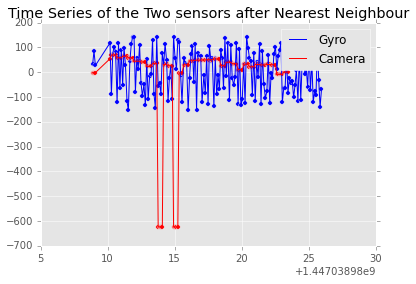

In [174]:
plt.plot(fused['timestamp_x'], fused['gz'] - fused['gz'].mean(), c = 'blue', label='Gyro' )
plt.scatter(fused['timestamp_x'], fused['gz'] - fused['gz'].mean(), c = 'blue', )
plt.plot(fused['timestamp_x'], fused['faceX'] - fused['faceX'].mean(), c='red', label='Camera')
plt.scatter(fused['timestamp_x'], fused['faceX'] - fused['faceX'].mean(), c='red')
plt.title('Time Series of the Two sensors after Nearest Neighbour')
plt.legend()

In [28]:
df_wheel.index
df_wheel['timestamp']

0     1.447039e+09
1     1.447039e+09
2     1.447039e+09
3     1.447039e+09
4     1.447039e+09
5     1.447039e+09
6     1.447039e+09
7     1.447039e+09
8     1.447039e+09
9     1.447039e+09
10    1.447039e+09
11    1.447039e+09
12    1.447039e+09
13    1.447039e+09
14    1.447039e+09
...
138    1.447039e+09
139    1.447039e+09
140    1.447039e+09
141    1.447039e+09
142    1.447039e+09
143    1.447039e+09
144    1.447039e+09
145    1.447039e+09
146    1.447039e+09
147    1.447039e+09
148    1.447039e+09
149    1.447039e+09
150    1.447039e+09
151    1.447039e+09
152    1.447039e+09
Name: timestamp, Length: 153, dtype: float64